In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from datetime import datetime

# Set style for better visuals
plt.style.use('seaborn')

/tmp/ipykernel_49345/3166615292.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
df = pd.read_csv('./dataset/bustabit.csv')

In [3]:
df.head()

,Id,GameID,Username,Bet,CashedOut,Bonus,Profit,BustedAt,PlayDate
0,14196549,3366002,papai,5,1.20,0.0,1.00,8.24,2016-11-20T19:44:19Z
1,10676217,3343882,znay22,3,NaN,NaN,NaN,1.40,2016-11-14T14:21:50Z
2,15577107,3374646,rrrrrrrr,4,1.33,3.0,1.44,3.15,2016-11-23T06:39:15Z
3,25732127,3429241,sanya1206,10,NaN,NaN,NaN,1.63,2016-12-08T18:13:55Z
4,17995432,3389174,ADM,50,1.50,1.4,25.70,2.29,2016-11-27T08:14:48Z


In [4]:
df.fillna(0, inplace=True)

In [5]:
# Convert 'PlayDate' to datetime
df['PlayDate'] = pd.to_datetime(df['PlayDate'])

# Find the last date in the dataset
latest_date = df['PlayDate'].max()

# Group by player and find their last activity date
player_churn_activity = df.groupby('Username')['PlayDate'].max().reset_index()

# Define churn threshold (e.g., 30 days)
churn_threshold_days = 4
player_churn_activity['Churned'] = (
    (latest_date - player_churn_activity['PlayDate']) > pd.Timedelta(days=churn_threshold_days)
).astype(int)

In [6]:
churn_counts = player_churn_activity['Churned'].value_counts()
print(churn_counts)

Churned
1    3245
0     904
Name: count, dtype: int64


In [7]:
# Merge churn status with original data
df = df.merge(player_churn_activity[['Username', 'Churned']], on='Username')

In [8]:
# Step 1: Get the last, second-last, and third-last play dates per player

player_activity = (
    df.sort_values('PlayDate')
    .groupby('Username')['PlayDate']
    .agg([
        ('LastPlayDate', 'last'),  # Most recent play (always exists)
        ('SecondLastPlayDate', lambda x: x.iloc[-2] if len(x) >= 2 else pd.NaT),
        ('ThirdLastPlayDate', lambda x: x.iloc[-3] if len(x) >= 3 else pd.NaT)
    ])
    .reset_index()
)

# Calculate days with fillna(0) at the end
player_activity['DaysSinceLastPlay'] = (latest_date - player_activity['LastPlayDate']).dt.days
player_activity['DaysSinceSecondLastPlay'] = (latest_date - player_activity['SecondLastPlayDate']).dt.days.fillna(0)
player_activity['DaysSinceThirdLastPlay'] = (latest_date - player_activity['ThirdLastPlayDate']).dt.days.fillna(0)

In [9]:
def generate_multiplied_array(input_value):
    result = []
    multiplier = 1
    while True:
        product = input_value * multiplier
        if product >= 40:
            break
        result.append(product)
        multiplier += 1
    return result

In [10]:
output_array = generate_multiplied_array(churn_threshold_days)
print(output_array)

[4, 8, 12, 16, 20, 24, 28, 32, 36]


In [11]:
# Define the time windows (in days)
#time_windows = [4, 8, 12, 16, 20, 24, 28, 32, 36]
time_windows = output_array

# Initialize a DataFrame to store results
player_bets_by_window = df[['Username']].drop_duplicates()

# Calculate bet sums for each time window
for days in time_windows:
    # Calculate cutoff date
    cutoff_date = latest_date - pd.Timedelta(days=days)
    
    # Filter bets and sum by player
    window_bets = (
        df[df['PlayDate'] >= cutoff_date]
        .groupby('Username')['Bet']
        .sum()
        .reset_index()
        .rename(columns={'Bet': f'BetsLast{days}Days'})
    )
    
    # Merge with main DataFrame
    player_bets_by_window = player_bets_by_window.merge(
        window_bets,
        on='Username',
        how='left'
    )

# Fill NA with 0 (for players with no bets in a window)
player_bets_by_window = player_bets_by_window.fillna(0)


In [12]:
player_last_activity = player_bets_by_window.merge(player_activity[['Username', 'DaysSinceLastPlay', 'DaysSinceSecondLastPlay', 'DaysSinceThirdLastPlay']], on='Username')

In [13]:
player_stats = df.groupby('Username').agg(
    TotalBetAmount=('Bet', 'sum'),
    TotalProfitAmount=('Profit', 'sum'),
    TotalBonusAmount=('Bonus', 'sum'),
    NumberOfBets=('Bet', 'count'),
    NumberOfBets_Won=('Profit', lambda x: (x > 0).sum()),  # Count wins (Profit > 0)
    NumberOfBets_Lost=('Profit', lambda x: (x <= 0).sum()), # Count losses (Profit <= 0)
    AverageBet=('Bet', 'mean'),
    MaxBet=('Bet', 'max'),
    MinBet=('Bet', 'min'),
    Churned=('Churned', 'first'),
).reset_index().sort_values('TotalBetAmount', ascending=False)

In [14]:
player_last_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Username                 4149 non-null   object 
 1   BetsLast4Days            4149 non-null   float64
 2   BetsLast8Days            4149 non-null   float64
 3   BetsLast12Days           4149 non-null   float64
 4   BetsLast16Days           4149 non-null   float64
 5   BetsLast20Days           4149 non-null   float64
 6   BetsLast24Days           4149 non-null   float64
 7   BetsLast28Days           4149 non-null   float64
 8   BetsLast32Days           4149 non-null   float64
 9   BetsLast36Days           4149 non-null   float64
 10  DaysSinceLastPlay        4149 non-null   int64  
 11  DaysSinceSecondLastPlay  4149 non-null   float64
 12  DaysSinceThirdLastPlay   4149 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 421.5+ KB


In [15]:
columns_to_select = [col for col in player_last_activity.columns ]
columns_to_select

['Username',
 'BetsLast4Days',
 'BetsLast8Days',
 'BetsLast12Days',
 'BetsLast16Days',
 'BetsLast20Days',
 'BetsLast24Days',
 'BetsLast28Days',
 'BetsLast32Days',
 'BetsLast36Days',
 'DaysSinceLastPlay',
 'DaysSinceSecondLastPlay',
 'DaysSinceThirdLastPlay']

In [16]:
# Merge churn status with original data
final_df = player_stats.merge(player_last_activity[columns_to_select], on='Username')
#final_df = player_stats.merge(player_last_activity[['Username', 'BetsLast4Days','BetsLast8Days','BetsLast12Days','BetsLast16Days','BetsLast20Days','BetsLast24Days','BetsLast28Days','BetsLast32Days','BetsLast36Days', 'DaysSinceLastPlay','DaysSinceSecondLastPlay','DaysSinceThirdLastPlay']], on='Username')

In [17]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Username                 4149 non-null   object 
 1   TotalBetAmount           4149 non-null   int64  
 2   TotalProfitAmount        4149 non-null   float64
 3   TotalBonusAmount         4149 non-null   float64
 4   NumberOfBets             4149 non-null   int64  
 5   NumberOfBets_Won         4149 non-null   int64  
 6   NumberOfBets_Lost        4149 non-null   int64  
 7   AverageBet               4149 non-null   float64
 8   MaxBet                   4149 non-null   int64  
 9   MinBet                   4149 non-null   int64  
 10  Churned                  4149 non-null   int64  
 11  BetsLast4Days            4149 non-null   float64
 12  BetsLast8Days            4149 non-null   float64
 13  BetsLast12Days           4149 non-null   float64
 14  BetsLast16Days          

In [18]:
final_df_corr = final_df.drop(['Username'], axis=1)

In [19]:
final_df_transform = final_df_corr.drop(['Churned'], axis=1)

In [20]:
final_df_transform = np.log1p(final_df_transform)

In [21]:
feature_df = final_df_corr.drop(['Churned'],axis=1)
list_of_features = [col for col in feature_df.columns ]
list_of_features

['TotalBetAmount',
 'TotalProfitAmount',
 'TotalBonusAmount',
 'NumberOfBets',
 'NumberOfBets_Won',
 'NumberOfBets_Lost',
 'AverageBet',
 'MaxBet',
 'MinBet',
 'BetsLast4Days',
 'BetsLast8Days',
 'BetsLast12Days',
 'BetsLast16Days',
 'BetsLast20Days',
 'BetsLast24Days',
 'BetsLast28Days',
 'BetsLast32Days',
 'BetsLast36Days',
 'DaysSinceLastPlay',
 'DaysSinceSecondLastPlay',
 'DaysSinceThirdLastPlay']

In [22]:
# cols_to_scale = ['TotalBetAmount','TotalProfitAmount','TotalBonusAmount',
#                  'NumberOfBets','NumberOfBets_Won','NumberOfBets_Lost','AverageBet',
#                  'MaxBet','MinBet', 'BetsLast4Days','BetsLast8Days','BetsLast12Days','BetsLast16Days',
#                  'BetsLast20Days','BetsLast24Days','BetsLast28Days','BetsLast32Days','BetsLast36Days',
#                  'DaysSinceLastPlay','DaysSinceSecondLastPlay','DaysSinceThirdLastPlay']
cols_to_scale = list_of_features

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()

In [25]:
#final_df[cols_to_scale] = scaler.fit_transform(final_df[cols_to_scale])
final_df_transform[cols_to_scale] = scaler.fit_transform(final_df_transform[cols_to_scale])

In [26]:
#features = final_df.drop(['Username', 'Churned'], axis=1)
features = final_df_transform

In [27]:
labels = final_df['Churned']

In [28]:
X = features
y = labels

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [31]:
X_train.shape

(3319, 21)

In [32]:
train_shape = X_train.shape[1]

In [33]:
import tensorflow as tf
from tensorflow import keras

2025-07-09 10:50:15.734528: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 10:50:15.957908: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 10:50:18.143564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [34]:
model = keras.Sequential([
    keras.layers.Dense(train_shape, input_shape=(train_shape,), activation='relu'),  # Note the colon (:) and comma
    #keras.layers.Dense(11, activation='relu'), # additional hidden layer
    keras.layers.Dense(1, activation='sigmoid')
])

In [35]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [36]:
model.fit(X_train,y_train, epochs=1)

104/104 [==============================] - 2s 4ms/step - loss: 0.4820 - accuracy: 0.7885


In [37]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 1s 5ms/step - loss: 0.3444 - accuracy: 0.8265


[0.34443575143814087, 0.8265060186386108]

In [38]:
yp = model.predict(X_test)
yp[:5]

26/26 [==============================] - 0s 3ms/step


array([[0.792304  ],
       [0.82502276],
       [0.50695646],
       [0.8691863 ],
       [0.76021886]], dtype=float32)

In [39]:
y_test[:10]

2391    1
1110    1
1494    0
2844    1
3995    1
2141    1
1130    0
3434    0
753     0
2657    1
Name: Churned, dtype: int64

In [40]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [41]:
y_pred[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [42]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [43]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29       174
           1       0.82      1.00      0.90       656

    accuracy                           0.83       830
   macro avg       0.91      0.59      0.60       830
weighted avg       0.86      0.83      0.77       830



Text(70.72222222222221, 0.5, 'Truth')

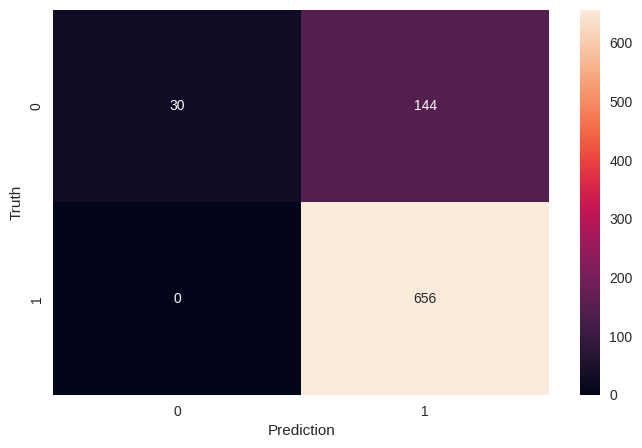

In [44]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize= (8,5))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

# Class counting

In [45]:
count_class_0, count_class_1 = final_df.Churned.value_counts()

In [46]:
count_class_0, count_class_1

(3245, 904)

In [47]:
df_class_0 = final_df[final_df['Churned'] == 1 ]
df_class_1 = final_df[final_df['Churned'] == 0 ]

In [48]:
df_class_0.shape

(3245, 23)

In [49]:
df_class_1.shape

(904, 23)

# under sampling

In [50]:
df_class_0_under = df_class_0.sample(count_class_1, replace=True)

In [51]:
df_class_0_under.shape

(904, 23)

In [52]:
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

In [53]:
df_test_under.shape

(1808, 23)

In [54]:
print('Random Under Sampling')
print(df_test_under.Churned.value_counts())

Random Under Sampling
Churned
1    904
0    904
Name: count, dtype: int64


In [55]:
under_sampling_df = df_test_under.drop(['Username','Churned'], axis=1)

In [56]:
under_sampling_df.head()

,TotalBetAmount,TotalProfitAmount,TotalBonusAmount,NumberOfBets,NumberOfBets_Won,NumberOfBets_Lost,AverageBet,MaxBet,MinBet,BetsLast4Days,...,BetsLast12Days,BetsLast16Days,BetsLast20Days,BetsLast24Days,BetsLast28Days,BetsLast32Days,BetsLast36Days,DaysSinceLastPlay,DaysSinceSecondLastPlay,DaysSinceThirdLastPlay
559,19393,8374.71,19.37,42,9,33,461.738095,5000,2,0.0,...,0.0,0.0,0.0,0.0,797.0,1999.0,18893.0,27,27.0,27.0
1069,5096,901.99,3.90,4,2,2,1274.000000,5000,10,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5076.0,34,35.0,38.0
2182,669,23.77,9.17,6,6,0,111.500000,600,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,37.0,37.0
1204,4000,1942.52,4.72,2,2,0,2000.000000,3000,1000,0.0,...,0.0,3000.0,3000.0,4000.0,4000.0,4000.0,4000.0,14,20.0,0.0
1516,2031,8166.77,8.34,6,1,5,338.500000,2000,1,0.0,...,2003.0,2031.0,2031.0,2031.0,2031.0,2031.0,2031.0,6,7.0,11.0


In [57]:
under_sampling_df.shape

(1808, 21)

In [58]:
under_sampling_df_transform = np.log1p(under_sampling_df)

In [59]:
under_sampling_df_transform[cols_to_scale] = scaler.fit_transform(under_sampling_df_transform[cols_to_scale])

In [60]:
X = under_sampling_df_transform
y = df_test_under['Churned']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [62]:
train_shape = X_train.shape[1]

In [63]:
model = keras.Sequential([
    keras.layers.Dense(train_shape, input_shape=(train_shape,), activation='relu'),  # Note the colon (:) and comma
    keras.layers.Dense(1, activation='sigmoid')
])

In [64]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [65]:
model.fit(X_train,y_train, epochs=1)

46/46 [==============================] - 2s 4ms/step - loss: 0.6212 - accuracy: 0.7178


In [66]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 3ms/step - loss: 0.5422 - accuracy: 0.8674


[0.5422132015228271, 0.8674033284187317]

In [67]:
yp = model.predict(X_test)
yp[:5]

12/12 [==============================] - 0s 3ms/step


array([[0.5978573 ],
       [0.45683277],
       [0.47848663],
       [0.5192117 ],
       [0.43260443]], dtype=float32)

In [68]:
y_test[:10]

2511    1
1283    1
2911    1
4035    1
1160    1
2555    1
1034    1
3013    1
3855    0
2088    1
Name: Churned, dtype: int64

In [69]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [70]:
y_pred[:10]

[1, 0, 0, 1, 0, 1, 0, 1, 0, 1]

In [71]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       184
           1       0.92      0.80      0.86       178

    accuracy                           0.87       362
   macro avg       0.87      0.87      0.87       362
weighted avg       0.87      0.87      0.87       362



Text(70.72222222222221, 0.5, 'Truth')

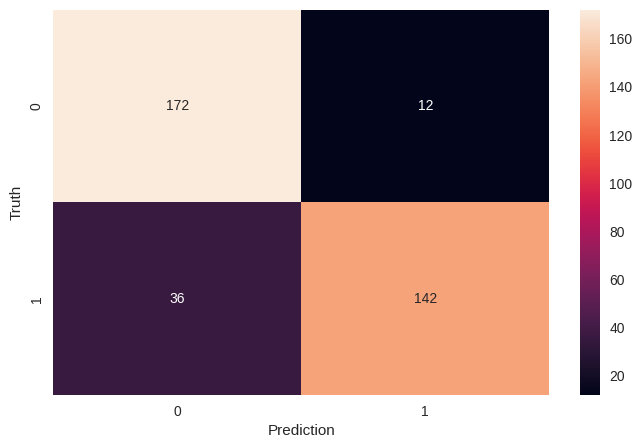

In [72]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize= (8,5))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

# Over Sampling

In [73]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over],axis=0)

In [74]:
df_test_over.shape

(6490, 23)

In [75]:
print('Random over-sampling:')
print(df_test_over.Churned.value_counts())

Random over-sampling:
Churned
1    3245
0    3245
Name: count, dtype: int64


In [76]:
over_sampling_df = df_test_over.drop(['Username','Churned'], axis=1)

In [77]:
over_sampling_df.head()

,TotalBetAmount,TotalProfitAmount,TotalBonusAmount,NumberOfBets,NumberOfBets_Won,NumberOfBets_Lost,AverageBet,MaxBet,MinBet,BetsLast4Days,...,BetsLast12Days,BetsLast16Days,BetsLast20Days,BetsLast24Days,BetsLast28Days,BetsLast32Days,BetsLast36Days,DaysSinceLastPlay,DaysSinceSecondLastPlay,DaysSinceThirdLastPlay
4,4469000,3803213.87,16.77,19,8,11,235210.526316,550000,70000,0.0,...,0.0,639000.0,1829000.0,2779000.0,2779000.0,3549000.0,3549000.0,13,15.0,15.0
5,2628100,313451.23,17.32,24,15,9,109504.166667,509000,13000,0.0,...,0.0,0.0,0.0,0.0,425500.0,694500.0,1271000.0,27,27.0,27.0
6,2561200,196276.45,11.46,9,6,3,284577.777778,500000,32500,0.0,...,0.0,0.0,2561200.0,2561200.0,2561200.0,2561200.0,2561200.0,16,16.0,16.0
7,2170100,222161.56,21.51,18,13,5,120561.111111,892000,24000,0.0,...,1087900.0,2074100.0,2170100.0,2170100.0,2170100.0,2170100.0,2170100.0,7,9.0,10.0
10,1984215,1226774.22,10.85,15,7,8,132281.000000,641024,34,0.0,...,1482368.0,1562368.0,1958224.0,1971480.0,1984051.0,1984115.0,1984115.0,8,9.0,9.0


In [78]:
over_sampling_df_transform = np.log1p(over_sampling_df)

In [79]:
over_sampling_df_transform[cols_to_scale] = scaler.fit_transform(over_sampling_df_transform[cols_to_scale])

In [80]:
X = over_sampling_df_transform
y = df_test_over['Churned']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [82]:
train_shape = X_train.shape[1]

In [83]:
model = keras.Sequential([
    keras.layers.Dense(train_shape, input_shape=(train_shape,), activation='relu'),  # Note the colon (:) and comma
    keras.layers.Dense(1, activation='sigmoid')
])

In [84]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [85]:
model.fit(X_train,y_train, epochs=1)

163/163 [==============================] - 2s 6ms/step - loss: 0.4658 - accuracy: 0.8844


In [86]:
model.evaluate(X_test, y_test)

41/41 [==============================] - 1s 5ms/step - loss: 0.3187 - accuracy: 0.9345


[0.3186957836151123, 0.9345146417617798]

In [87]:
yp = model.predict(X_test)
yp[:5]

41/41 [==============================] - 0s 6ms/step


array([[0.24660586],
       [0.7679846 ],
       [0.7448044 ],
       [0.7151332 ],
       [0.5464352 ]], dtype=float32)

In [88]:
y_test[:10]

1238    0
2917    1
2519    1
4112    1
2671    1
42      0
1923    0
2998    0
1288    0
3971    1
Name: Churned, dtype: int64

In [89]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [90]:
y_pred[:10]

[0, 1, 1, 1, 1, 0, 0, 0, 0, 1]

In [91]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       663
           1       0.92      0.95      0.93       635

    accuracy                           0.93      1298
   macro avg       0.93      0.93      0.93      1298
weighted avg       0.94      0.93      0.93      1298



Text(70.72222222222221, 0.5, 'Truth')

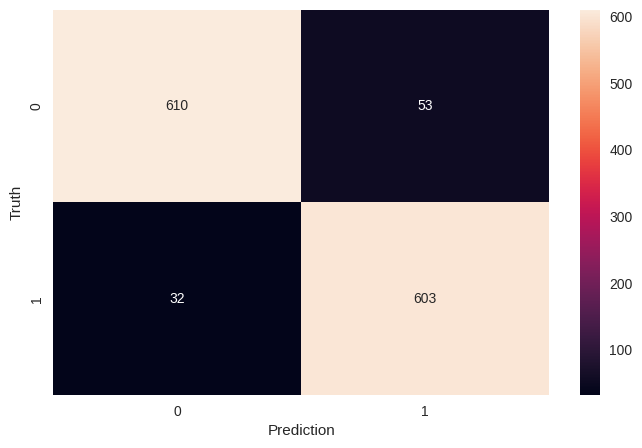

In [92]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize= (8,5))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')